In [ ]:
import pandas as pd
import numpy as np
from math import pi
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Bitcoin_Data.csv")


In [ ]:
styled_df = df.head(6).style.set_table_styles(
    [{'selector': 'thead', 'props': [('background-color', 'black'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', 'lightgray')]},
     {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

styled_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.390000,4.390000,4.390000,4.390000,0.455581,2.000000,4.390000
1,1325317980,nan,nan,nan,nan,nan,nan,nan
2,1325318040,nan,nan,nan,nan,nan,nan,nan
3,1325318100,nan,nan,nan,nan,nan,nan,nan
4,1325318160,nan,nan,nan,nan,nan,nan,nan
5,1325318220,nan,nan,nan,nan,nan,nan,nan


In [ ]:
df.shape

(4857377, 8)

<Axes: title={'center': 'Distribution of Transaction Time'}, ylabel='Density'>

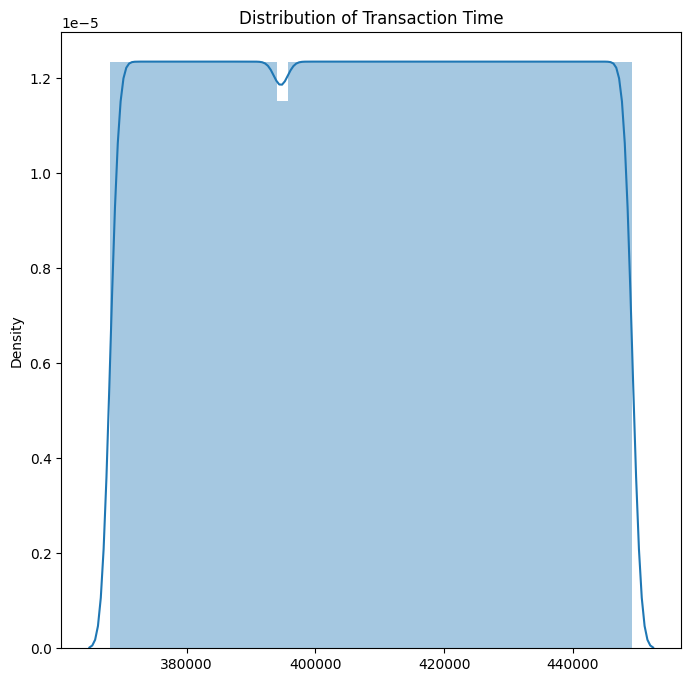

In [ ]:
plt.figure(figsize=(8,8))

plt.title('Distribution of Transaction Time')
sns.distplot(df['Timestamp'].values/(60*60))

In [ ]:
correlation_matrix = df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                   Timestamp      Open      High       Low     Close  \
Timestamp           1.000000  0.650719  0.650644  0.650803  0.650714   
Open                0.650719  1.000000  0.999999  0.999999  0.999999   
High                0.650644  0.999999  1.000000  0.999998  0.999999   
Low                 0.650803  0.999999  0.999998  1.000000  0.999999   
Close               0.650714  0.999999  0.999999  0.999999  1.000000   
Volume_(BTC)       -0.103926 -0.051860 -0.051717 -0.052040 -0.051877   
Volume_(Currency)   0.228190  0.344074  0.344498  0.343541  0.344036   
Weighted_Price      0.650737  0.999999  0.999999  1.000000  1.000000   

                   Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp             -0.103926           0.228190        0.650737  
Open                  -0.051860           0.344074        0.999999  
High                  -0.051717           0.344498        0.999999  
Low                   -0.052040           0.343541     

<Axes: ylabel='count'>

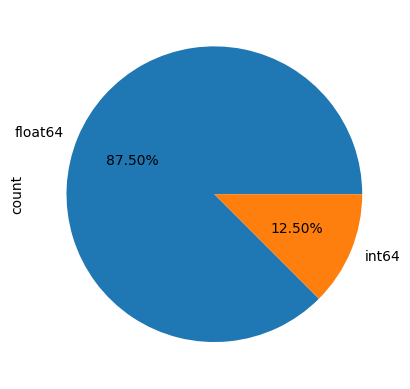

In [ ]:
df.dtypes.value_counts().plot.pie(autopct=('%0.2f%%'))

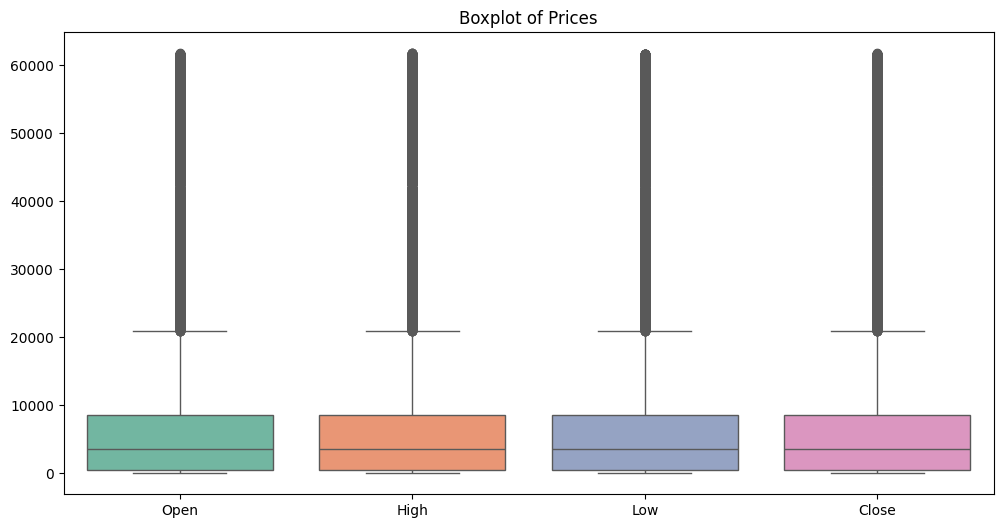

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']], palette='Set2')
plt.title('Boxplot of Prices')
plt.show()

In [ ]:
unique_values = df.nunique()
print("Unique Values:")
print(unique_values)

Unique Values:
Timestamp            4857377
Open                 1059732
High                 1030826
Low                  1046536
Close                1058685
Volume_(BTC)         3181865
Volume_(Currency)    3562603
Weighted_Price       3046022
dtype: int64


<Axes: >

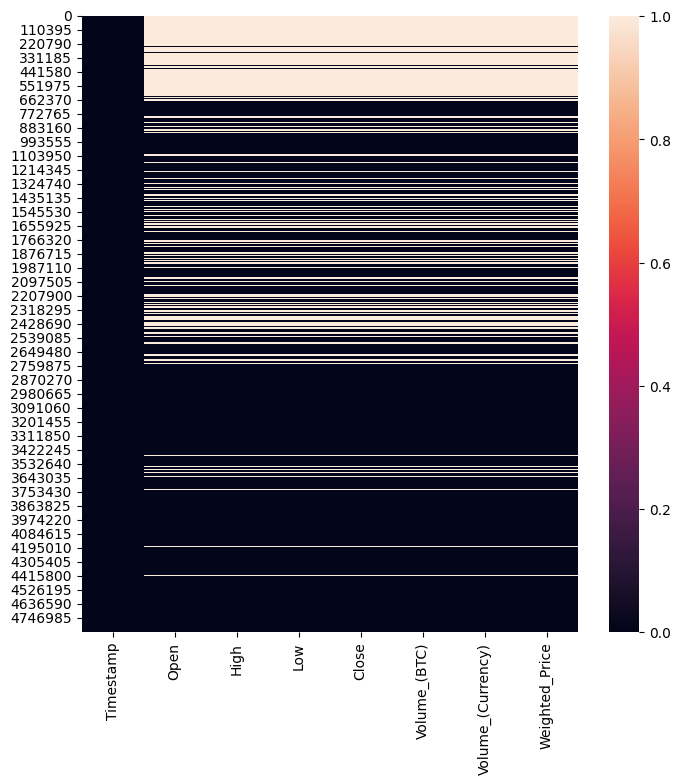

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull())

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64


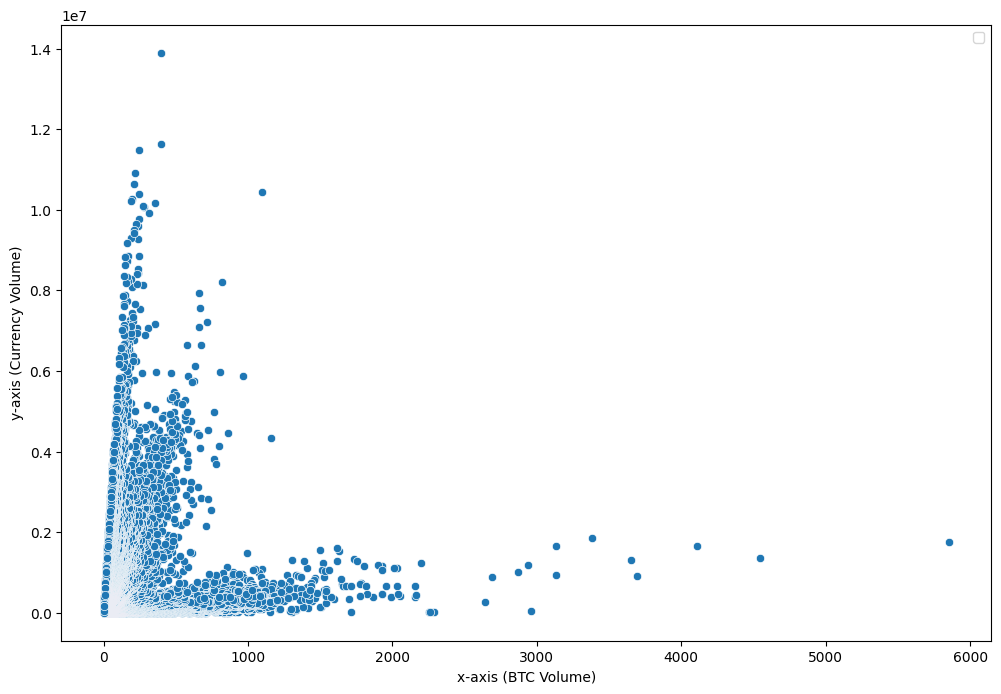

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Volume_(BTC)', y='Volume_(Currency)', data=df)
plt.xlabel("x-axis (BTC Volume)")
plt.ylabel("y-axis (Currency Volume)")
plt.legend()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


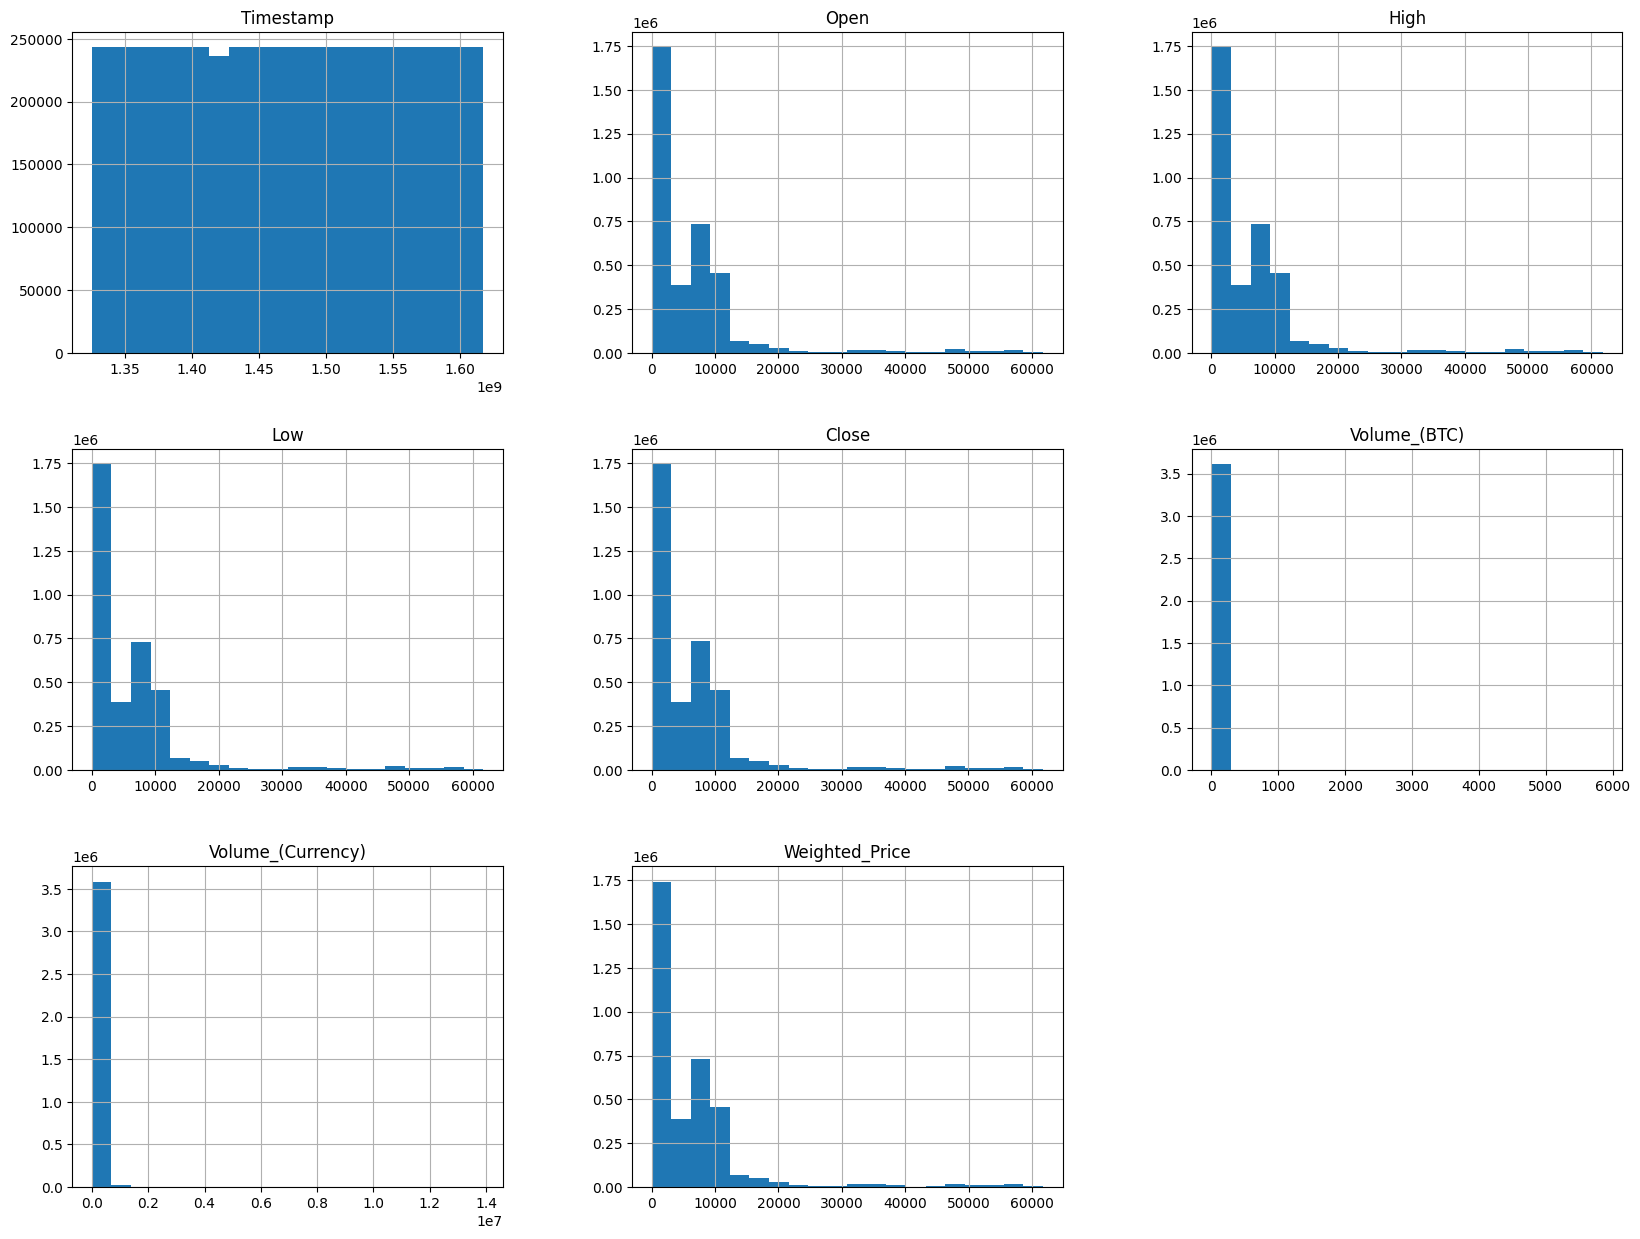

In [ ]:
df.hist(bins=20, legend=False, figsize=(20, 15))
plt.show()

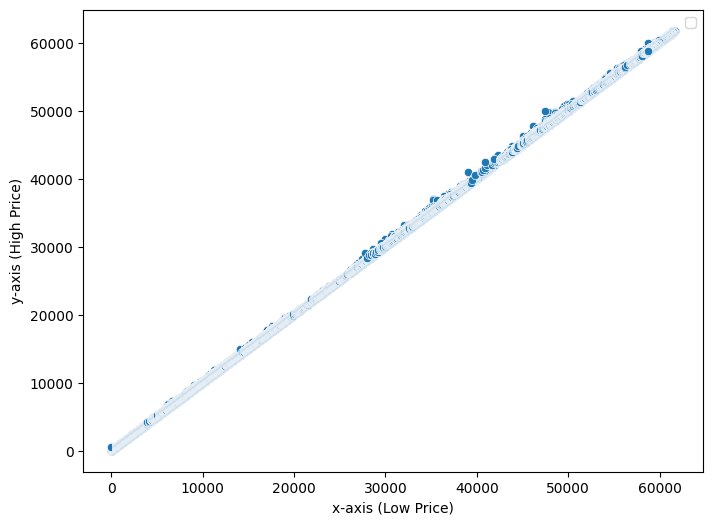

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Low', y='High', data=df)
plt.xlabel("x-axis (Low Price)")
plt.ylabel("y-axis (High Price)")
plt.legend()
plt.show()

In [ ]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [ ]:
df = df.dropna()
df = df.drop_duplicates()

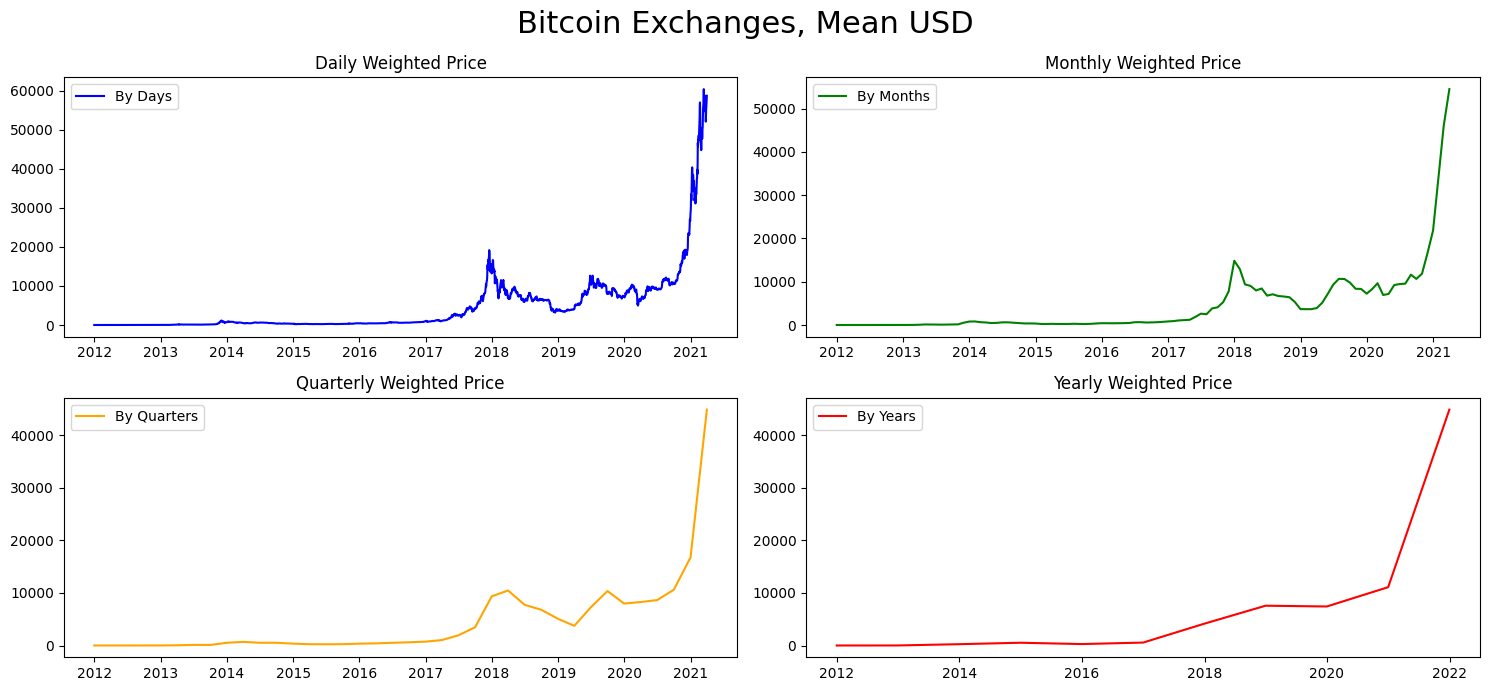

In [ ]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

df.index = df.Timestamp

df_day = df.resample('D').mean()

df_month = df.resample('M').mean()

df_year = df.resample('A-DEC').mean()

df_Q = df.resample('Q-DEC').mean()

# Create a figure for the subplots
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Exchanges, Mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_day.index, df_day['Weighted_Price'], '-', label='By Days', color='blue')
plt.legend(loc='best')
plt.title('Daily Weighted Price')

plt.subplot(222)
plt.plot(df_month.index, df_month['Weighted_Price'], '-', label='By Months', color='green')
plt.legend(loc='best')
plt.title('Monthly Weighted Price')

plt.subplot(223)
plt.plot(df_Q.index, df_Q['Weighted_Price'], '-', label='By Quarters', color='orange')
plt.legend(loc='best')
plt.title('Quarterly Weighted Price')

plt.subplot(224)
plt.plot(df_year.index, df_year['Weighted_Price'], '-', label='By Years', color='red')
plt.legend(loc='best')
plt.title('Yearly Weighted Price')

plt.tight_layout()
plt.show()

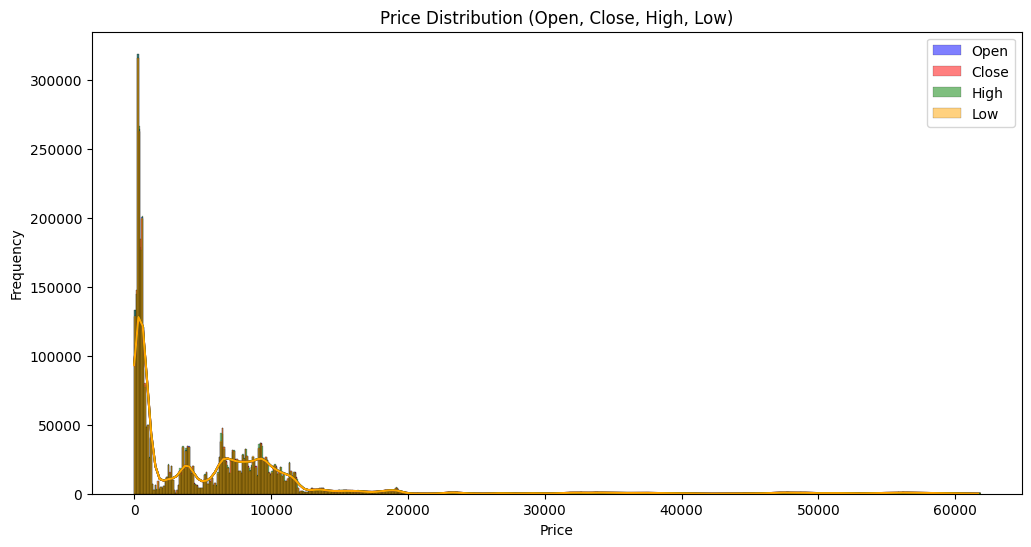

In [ ]:
# Price Distribution of 'Open', 'Close', 'High', 'Low'
plt.figure(figsize=(12, 6))
sns.histplot(df['Open'], kde=True, label='Open', color='blue')
sns.histplot(df['Close'], kde=True, label='Close', color='red')
sns.histplot(df['High'], kde=True, label='High', color='green')
sns.histplot(df['Low'], kde=True, label='Low', color='orange')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution (Open, Close, High, Low)')
plt.legend()
plt.show()

Dickey–Fuller test: p=0.998833


<Figure size 1500x700 with 0 Axes>

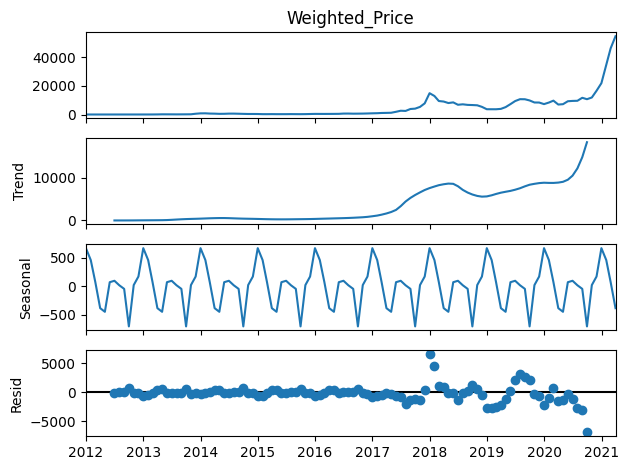

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
print(df)

                              Timestamp      Open      High       Low  \
Timestamp                                                               
2011-12-31 07:52:00 2011-12-31 07:52:00      4.39      4.39      4.39   
2011-12-31 15:50:00 2011-12-31 15:50:00      4.39      4.39      4.39   
2011-12-31 16:59:00 2011-12-31 16:59:00      4.50      4.57      4.50   
2011-12-31 17:00:00 2011-12-31 17:00:00      4.58      4.58      4.58   
2012-01-01 04:16:00 2012-01-01 04:16:00      4.58      4.58      4.58   
...                                 ...       ...       ...       ...   
2021-03-30 23:56:00 2021-03-30 23:56:00  58714.31  58714.31  58686.00   
2021-03-30 23:57:00 2021-03-30 23:57:00  58683.97  58693.43  58683.97   
2021-03-30 23:58:00 2021-03-30 23:58:00  58693.43  58723.84  58693.43   
2021-03-30 23:59:00 2021-03-30 23:59:00  58742.18  58770.38  58742.18   
2021-03-31 00:00:00 2021-03-31 00:00:00  58767.75  58778.18  58755.97   

                        Close  Volume_(BTC)  Volum

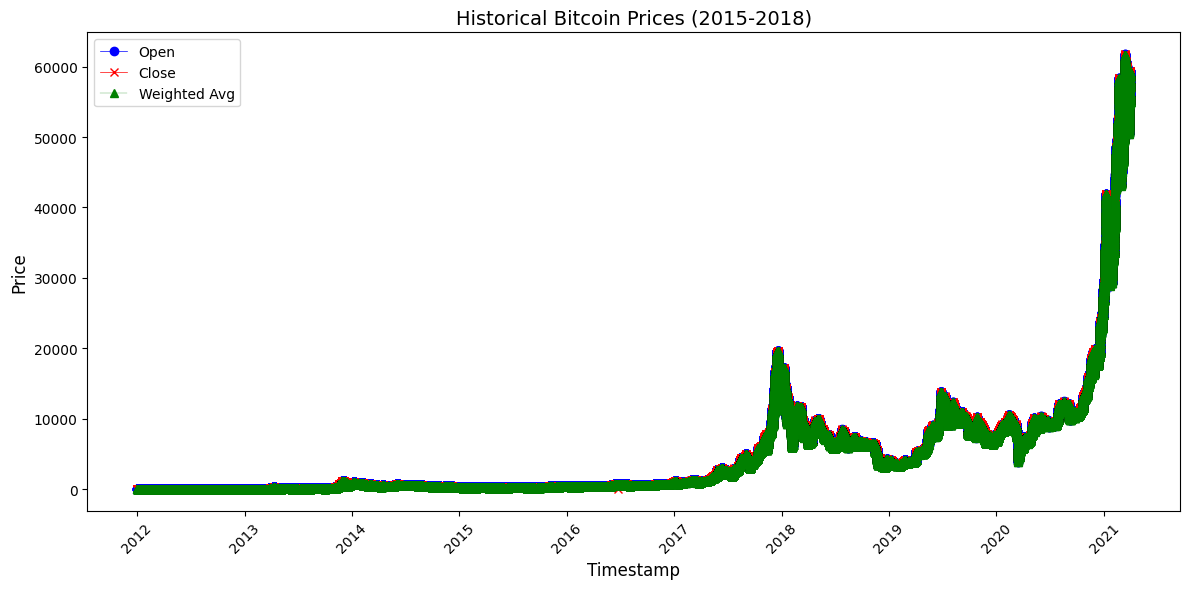

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Timestamp'], df['Open'].astype(float), label='Open', color='blue', linestyle='-', marker='o', linewidth=0.5)
ax.plot(df['Timestamp'], df['Close'].astype(float), label='Close', color='red', linestyle='-', marker='x', linewidth=0.5)
ax.plot(df['Timestamp'], df['Weighted_Price'].astype(float), label='Weighted Avg', color='green', linestyle='-', marker='^', linewidth=0.2)

# Set title and labels
ax.set_title('Historical Bitcoin Prices (2015-2018)', fontsize=14)
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

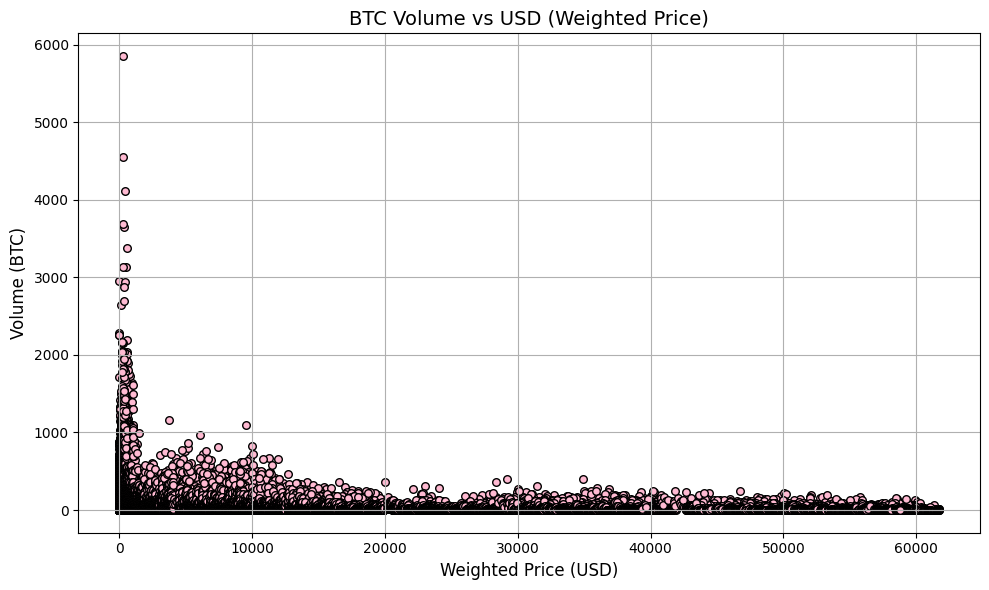

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for BTC Volume vs Weighted Price (USD)
ax.scatter(
    df['Weighted_Price'].astype(float),
    df['Volume_(BTC)'].astype(float),
    color='#FFBAD2',
    edgecolors='black',
    s=30,
)

# Set title and labels
ax.set_title('BTC Volume vs USD (Weighted Price)', fontsize=14)
ax.set_xlabel('Weighted Price (USD)', fontsize=12)
ax.set_ylabel('Volume (BTC)', fontsize=12)

ax.grid(True)

plt.tight_layout()
plt.show()

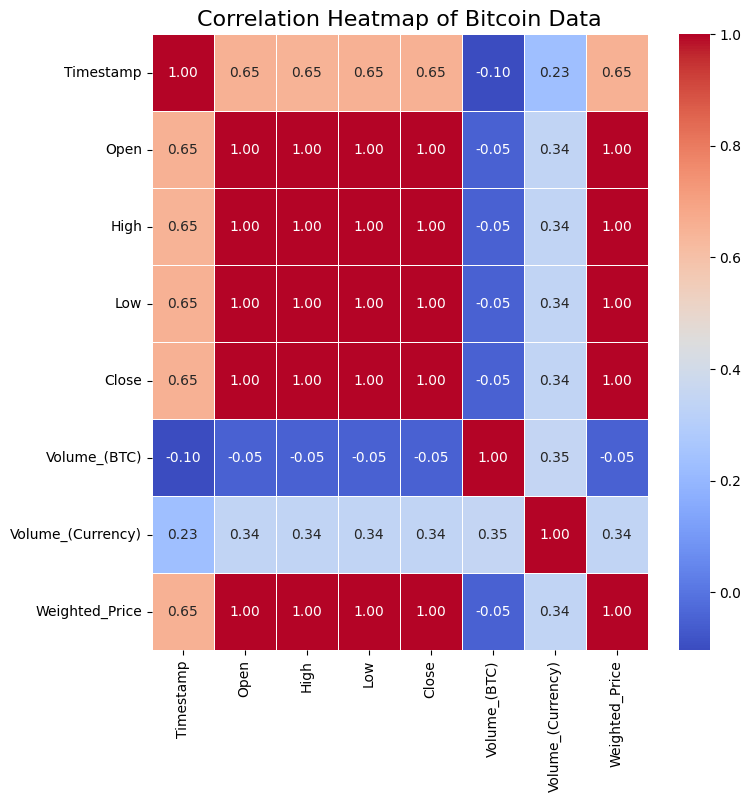

In [ ]:
plt.figure(figsize=(8, 8))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Bitcoin Data', fontsize=16)
plt.show()

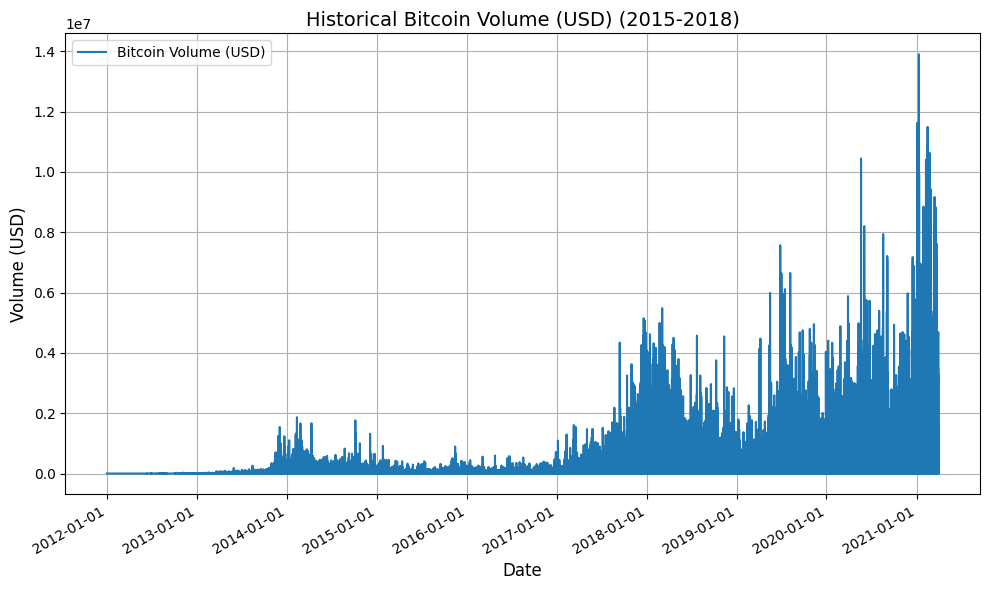

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['Timestamp'],
        df['Volume_(Currency)'].astype(float),
        color='tab:blue', label='Bitcoin Volume (USD)')

ax.set_title('Historical Bitcoin Volume (USD) (2015-2018)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Volume (USD)', fontsize=12)

ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
df.index = df.Timestamp
df.drop(columns=['Timestamp'], inplace=True)
df.dropna(inplace=True)

In [ ]:
df['Log_Price'] = np.log(df['Weighted_Price'] + 1)

In [ ]:
X = df.drop(columns=['Weighted_Price', 'Log_Price'])
y = df['Log_Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
results = []

In [ ]:
# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

# Evaluate
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
knn_mae = mean_absolute_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)

print(f"KNN Results:")
print(f"RMSE: {knn_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {knn_mae:.4f}")
print(f"R² Score: {knn_r2:.4f}")

results.append(['KNN', knn_rmse, knn_mae, knn_r2])

KNN Results:
RMSE: 0.0134
Mean Absolute Error (MAE): 0.0022
R² Score: 0.9999


In [ ]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Evaluate
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

# Print results
print(f"Gradient Boosting Regressor Results:")
print(f"RMSE: {gb_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {gb_mae:.4f}")
print(f"R² Score: {gb_r2:.4f}")

results.append(['Gradient Boosting Regressor', gb_rmse, gb_mae, gb_r2])

Gradient Boosting Regressor Results:
RMSE: 0.0123
Mean Absolute Error (MAE): 0.0083
R² Score: 0.9999


In [ ]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

# Print results
print(f"XGBoost Regressor Results:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.4f}")
print(f"R² Score: {xgb_r2:.4f}")

results.append(['XGBoost Regressor', xgb_rmse, xgb_mae, xgb_r2])

XGBoost Regressor Results:
RMSE: 0.0147
Mean Absolute Error (MAE): 0.0068
R² Score: 0.9999


In [ ]:
# AdaBoost Regressor
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train, y_train)

adaboost_pred = adaboost_model.predict(X_test)

adaboost_rmse = np.sqrt(mean_squared_error(y_test, adaboost_pred))
adaboost_mae = mean_absolute_error(y_test, adaboost_pred)
adaboost_r2 = r2_score(y_test, adaboost_pred)

# Print results
print(f"AdaBoostRegressor Results:")
print(f"RMSE: {adaboost_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {adaboost_mae:.4f}")
print(f"R² Score: {adaboost_r2:.4f}")

results.append(['AdaBoostRegressor', adaboost_rmse, adaboost_mae, adaboost_r2])

AdaBoostRegressor Results:
RMSE: 0.1223
Mean Absolute Error (MAE): 0.1006
R² Score: 0.9950


In [ ]:
results_df1 = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])
print(results_df1)

                         Model      RMSE       MAE        R2
0                          KNN  0.013384  0.002248  0.999940
1  Gradient Boosting Regressor  0.012313  0.008303  0.999949
2            XGBoost Regressor  0.014714  0.006841  0.999927
3            AdaBoostRegressor  0.122271  0.100602  0.994964


In [ ]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [ ]:
# Update input shape for CNN
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Build CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(8, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])

cnn_model.compile(optimizer='adam', loss='mse')

history_cnn = cnn_model.fit(X_train_lstm, y_train_scaled, epochs=5, batch_size=64, verbose=1, validation_data=(X_test_lstm, y_test_scaled))

# Predictions with CNN
y_pred_scaled_cnn = cnn_model.predict(X_test_lstm)
y_pred_cnn = scaler_y.inverse_transform(y_pred_scaled_cnn)
y_actual = y_test.values

# Evaluation Metrics
cnn_rmse = np.sqrt(mean_squared_error(y_actual, y_pred_cnn))
cnn_mae = mean_absolute_error(y_actual, y_pred_cnn)
cnn_r2 = r2_score(y_actual, y_pred_cnn)

print(f"CNN Results:")
print(f"RMSE: {cnn_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {cnn_mae:.4f}")
print(f"R² Score: {cnn_r2:.4f}")

Epoch 1/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 226s 5ms/step - loss: 0.0066 - val_loss: 1.2502e-04
Epoch 2/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 265s 5ms/step - loss: 0.0011 - val_loss: 1.9787e-05
Epoch 3/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - loss: 0.0010 - val_loss: 6.7613e-05
Epoch 4/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 281s 5ms/step - loss: 0.0010 - val_loss: 3.3131e-05
Epoch 5/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 220s 5ms/step - loss: 0.0010 - val_loss: 3.3955e-05
22587/22587 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
CNN Results:
RMSE: 0.0551
Mean Absolute Error (MAE): 0.0445
R² Score: 0.9990


Epoch 1/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 256s 6ms/step - loss: 0.0078 - val_loss: 3.5892e-05
Epoch 2/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 272s 6ms/step - loss: 0.0012 - val_loss: 6.5422e-05
Epoch 3/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 317s 6ms/step - loss: 0.0011 - val_loss: 7.0889e-05
Epoch 4/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 320s 6ms/step - loss: 0.0011 - val_loss: 8.2908e-05
Epoch 5/5
45173/45173 ━━━━━━━━━━━━━━━━━━━━ 315s 6ms/step - loss: 0.0011 - val_loss: 4.5315e-05
22587/22587 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
LSTM Results:
RMSE: 0.0637
Mean Absolute Error (MAE): 0.0508
R² Score: 0.9986


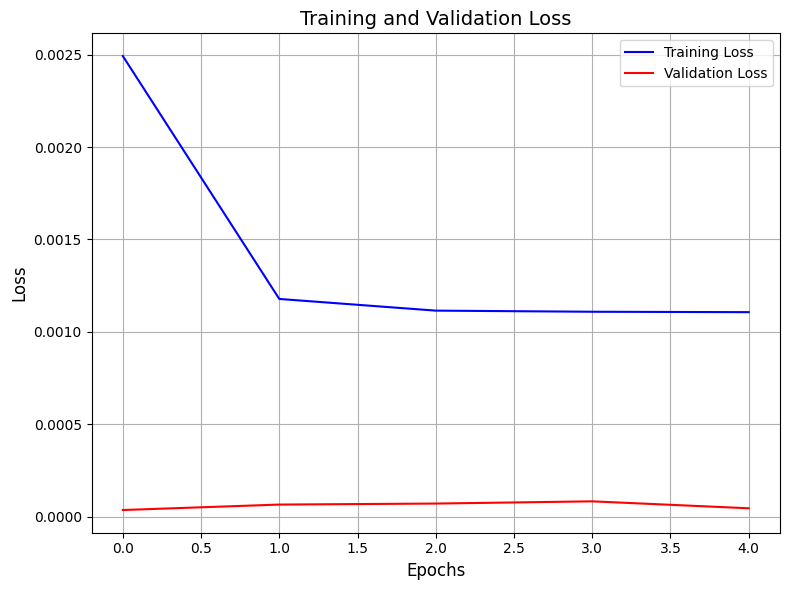

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(8, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train_scaled, epochs=5, batch_size=64, verbose=1, validation_data=(X_test_lstm, y_test_scaled))

# Predictions
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = y_test.values

# Calculate evaluation metrics
lstm_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
lstm_mae = mean_absolute_error(y_actual, y_pred)
lstm_r2 = r2_score(y_actual, y_pred)

print(f"LSTM Results:")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {lstm_mae:.4f}")
print(f"R² Score: {lstm_r2:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history.get('val_loss', []), label='Validation Loss', color='red')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
knn_results = ['K-Nearest Neighbors', knn_rmse, knn_mae, knn_r2]
gb_results = ['Gradient Boosting Regressor', gb_rmse, gb_mae, gb_r2]
xgb_results = ['XGBoost Regressor', xgb_rmse, xgb_mae, xgb_r2]
adaboost_results = ['AdaBoost Regressor', adaboost_rmse, adaboost_mae, adaboost_r2]
cnn_results = ['CNN', cnn_rmse, cnn_mae, cnn_r2]
lstm_results = ['LSTM', lstm_rmse, lstm_mae, lstm_r2]

results = [knn_results, gb_results, xgb_results, adaboost_results, lstm_results,cnn_results]

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])
print("Model Comparison Results:")
print(results_df)

# Add ranking based on RMSE
results_df['Rank'] = results_df['RMSE'].rank(method='min', ascending=True)
ranked_df = results_df.sort_values(by='Rank')
print("\nRanked Models:")
print(ranked_df)

Model Comparison Results:
                         Model      RMSE       MAE        R2
0          K-Nearest Neighbors  0.013384  0.002248  0.999940
1  Gradient Boosting Regressor  0.012313  0.008303  0.999949
2            XGBoost Regressor  0.014714  0.006841  0.999927
3           AdaBoost Regressor  0.122271  0.100602  0.994964
4                         LSTM  0.063691  0.050789  0.998633
5                          CNN  0.055133  0.044548  0.998976

Ranked Models:
                         Model      RMSE       MAE        R2  Rank
1  Gradient Boosting Regressor  0.012313  0.008303  0.999949   1.0
0          K-Nearest Neighbors  0.013384  0.002248  0.999940   2.0
2            XGBoost Regressor  0.014714  0.006841  0.999927   3.0
5                          CNN  0.055133  0.044548  0.998976   4.0
4                         LSTM  0.063691  0.050789  0.998633   5.0
3           AdaBoost Regressor  0.122271  0.100602  0.994964   6.0


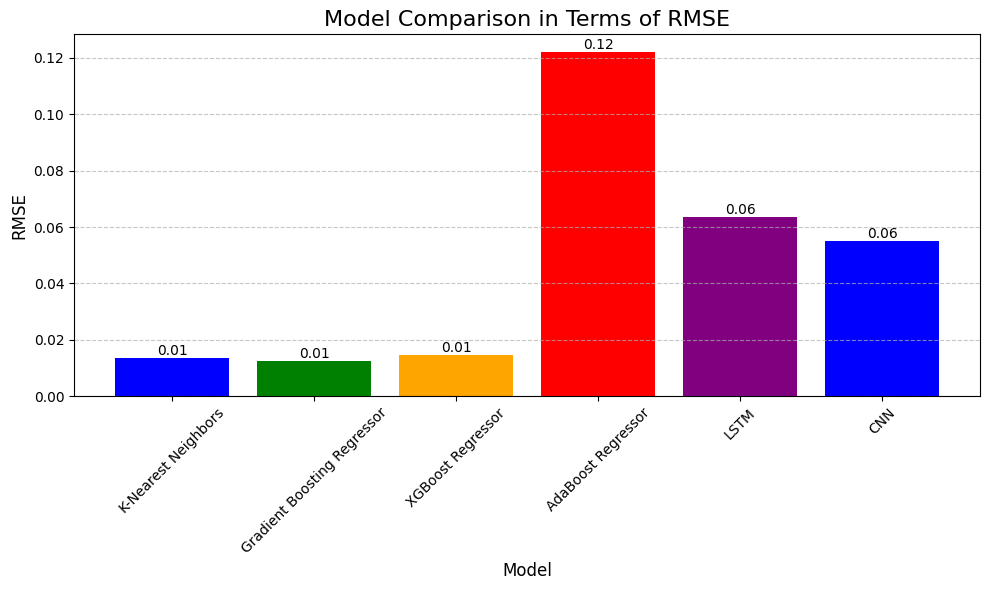

In [ ]:
# Bar Plot with Annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['RMSE'], color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Comparison in Terms of RMSE', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

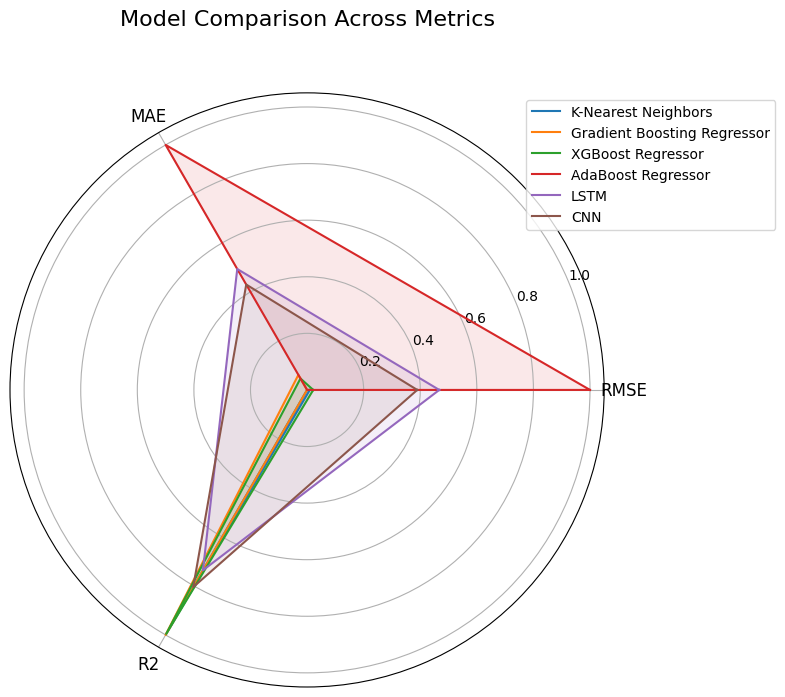

In [ ]:
metrics = ['RMSE', 'MAE', 'R2']
normalized_df = results_df.copy()
for metric in metrics:
    normalized_df[metric] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

categories = metrics
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(8, 8))

for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row['Model'])
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories, fontsize=12)
plt.title('Model Comparison Across Metrics', fontsize=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

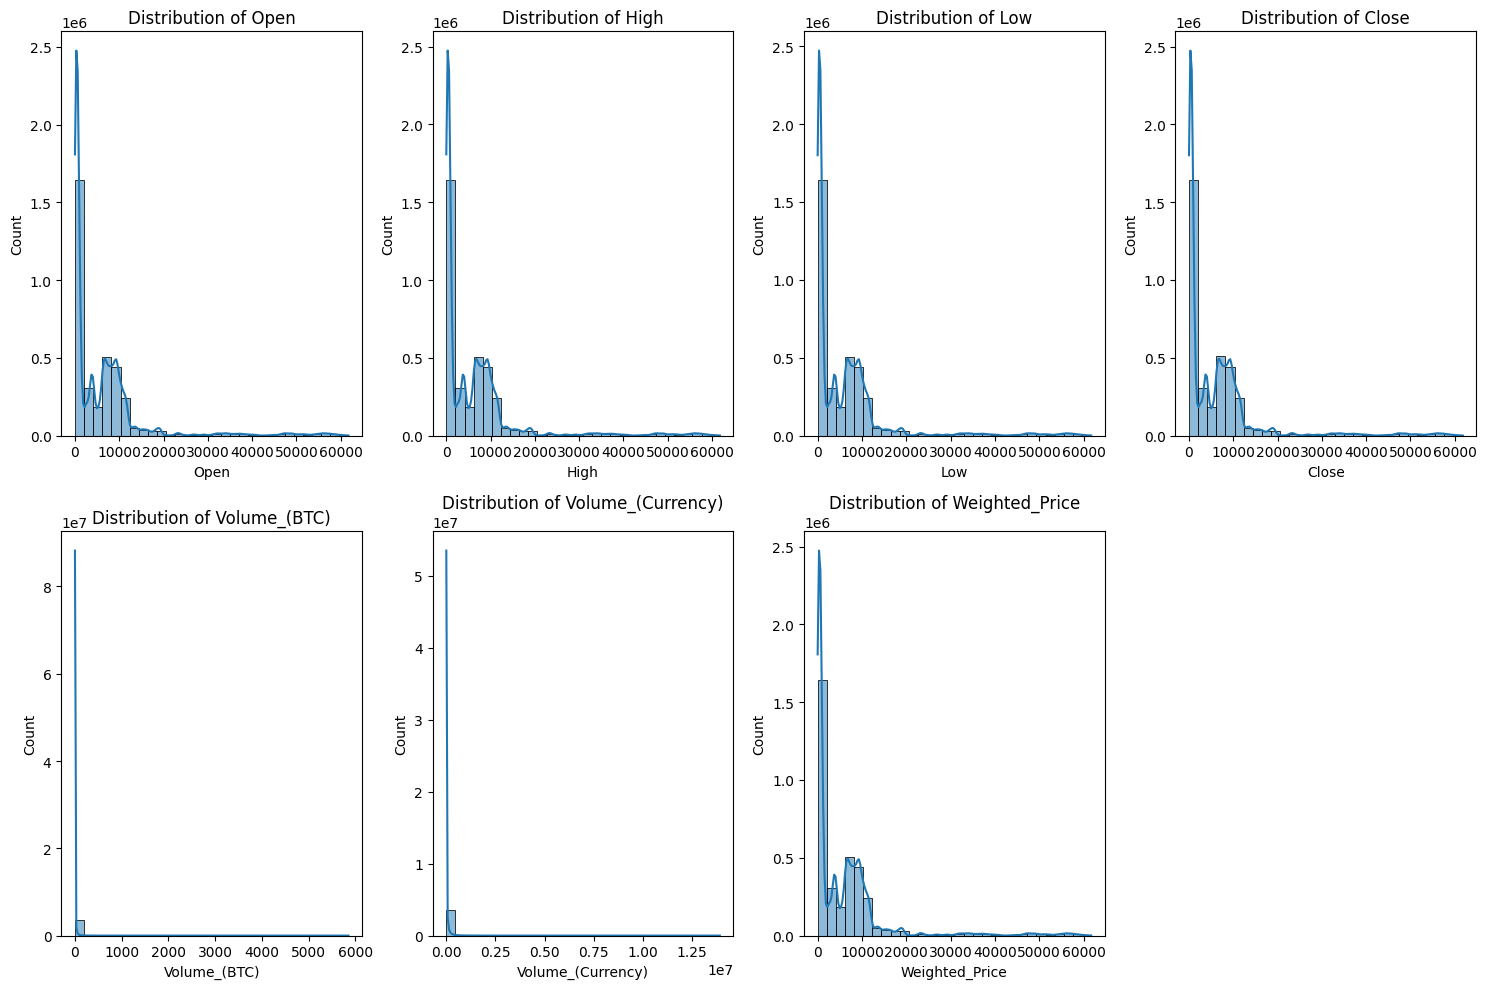

In [ ]:
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()